In [1]:
import time
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

from astro import astroutils
from astro import mastrometry
from astro import mimage
from astro import mphot

from utils import mutils
from utils import mlogging 

from util.data import pload, psave, doublesort

from astro.astroutils import jd2UTCtimestamp, UTCtimestamp2jd

log = mlogging.getLogger('photometry')

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

target= ('08 19 28.99', '70 42 19.4') # SIMBAD values is correct
comps = [     
            ('08 19 35.27861', '70 42 46.68284'), # A=1774 SNR=592   stdev = 0.2 (previously #1)  
            ('08 19 42.614',   '70 40 23.9842'),    # A=4800 SNR=1078 stdev = 0.05 (previously #5)
            ('08 19 57.87424', '70 42 53.07892'),   # A=2295 SNR=775 stdev = 0.03 (previously #6)
            ('08 19 33.91390', '70 44 27.99391'),   # A=3500 SNR=904      
            ('08 19 15.57437', '70 44 42.37452'),   # A=2014 SNR=637.7
        ]

In [ ]:
"""
3.8 6.999999999999999 15.0
6.08 11.2 24.000000000000004
2.8085454545454547 5.173636363636363 11.086363636363636
2.0596 3.7939999999999996 8.13
"""

for c in comps:
    print(mphot.equatorial2pix(c, '/Users/canis/dev/holmberg/data/test/calibrated/g21d018.050.a.fits'))

In [ ]:
"""Just aperphot (has it's own local subtraction)"""
files, seeings = pload('seeings.p')
dr = 3.8
bw = 7
sa = 15
saturation=28000
cntrds = mphot.aperphot(files, startcoords=target,
                            compcoords=comps, ncompmax=5, snrmin=100,
                            diskradius=dr, bufferwidth=bw, skyannulus=sa,
                            Nthresh=2.4, autoradius='fixed', emax=0.5,
                            saturation=saturation,
                            nhist=1, quick='noctrd', maxcpus=None, verbose=True)


In [ ]:
"""aperphot with global Background2D subtraction"""

In [74]:
"""photutils.aperture with global Background2D subtraction """
# https://photutils.readthedocs.io/en/stable/aperture.html
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
seeings_dict = pload('seeings.p')
files = seeings_dict['files']
seeings = seeings_dict['seeings']

times = seeings_dict['times']
dmags = []

results = []
print(len(files))
for i, fn in enumerate(files[0:]):
    print(f'{i} ', end="")
    objs = [target] + comps
    coords = []
    for obj in objs:
        x, y = mphot.equatorial2pix(obj, fn)
        x = x.flat[0]
        y = y.flat[0]
        coords.append((x,y))
    hdul = fits.open(fn)
    image = hdul[1].data
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bg = Background2D(image, (50, 50), filter_size=(3, 3), 
        sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    aperture = CircularAperture(coords, r=3.8)
    phot_table = aperture_photometry(image-bg.background, aperture)
    results.append(phot_table)

    dmags.append(-2.5 * np.log(phot_table['aperture_sum'][0]/np.mean(phot_table['aperture_sum'][1:])))
psave(results, 'results.p')

959
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 27

hey


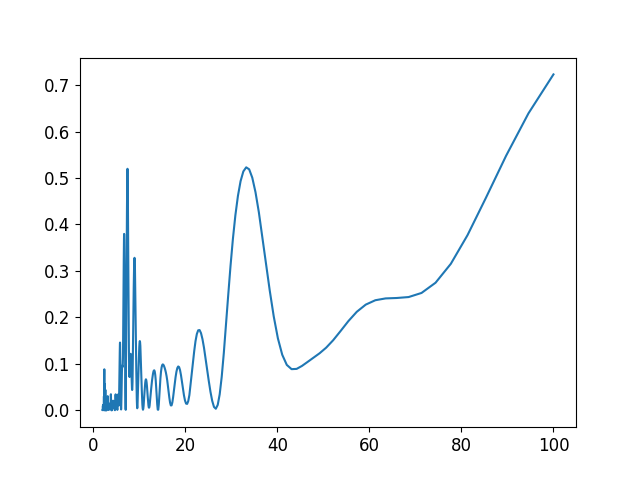

In [115]:
from astropy.timeseries import LombScargle
from util.timeseriestools import dt64_to_days, Timeseries, remove_nans
from astropy.table import vstack

results = pload('results.p')
seeings_dict = pload('seeings.p')
files = seeings_dict['files']
seeings = seeings_dict['seeings']

def ls(t, y, probabilities = [0.1, 0.05, 0.01]):
    print('hey')
    t_new, y_new = remove_nans(dt64_to_days(t), y)
    ls = LombScargle(t_new, y_new)
    frequency, power = ls.autopower(samples_per_peak=20, minimum_frequency=1/100, maximum_frequency=1/2)
    faps = ls.false_alarm_level(probabilities)
    return frequency, power, faps

N = 1 + len(comps)

# plt.figure(figsize=(10,10))
# ax = plt.subplot(N, 1, 1)
# times = seeings_dict['times']
# dmags = [-2.5 * np.log(phot_table['aperture_sum'][0]/np.mean(phot_table['aperture_sum'][1:])) for phot_table in results]
# frequency, power, faps = ls(times, dmags)
# plt.plot(1/frequency, power)
# plt.xlim(0,100)

plt.figure()
times = seeings_dict['times']
dmags = [-2.5 * np.log(phot_table['aperture_sum'][0]/np.mean(phot_table['aperture_sum'][1:])) for phot_table in results]
frequency, power, faps = ls(times, dmags)
plt.plot(1/frequency, power)


# for i in range(len(comps)):
#     ax = plt.subplot(N, 1, i+2)
#     times = seeings_dict['times']
#     dmags = [-2.5 * np.log(phot_table['aperture_sum'][i]/np.mean(vstack([phot_table['aperture_sum'][1:i+1], phot_table['aperture_sum'][i+2:]])['aperture_sum'])) 
#             for phot_table in results]
#     frequency, power, faps = ls(times, dmags)
#     plt.xlim(0,100)
#     plt.plot(1/frequency, power)
# plt.tight_layout()

(0.0, 100.0)

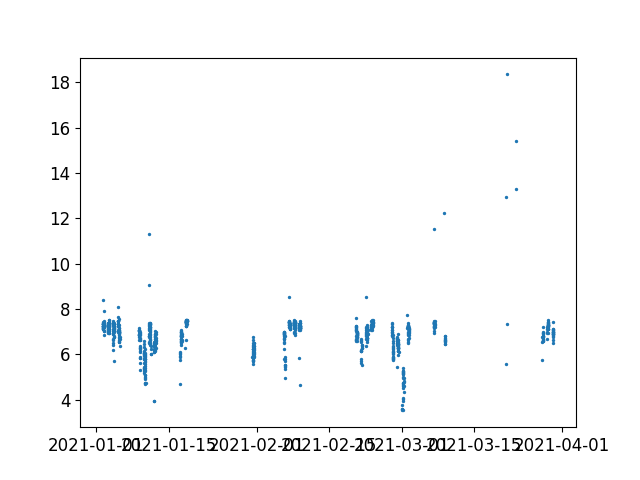

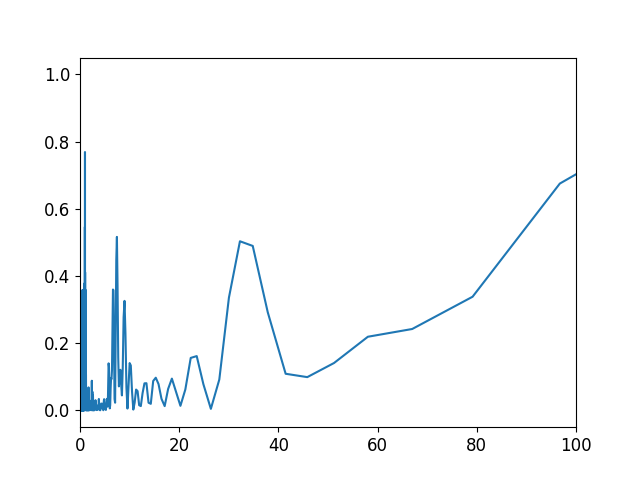

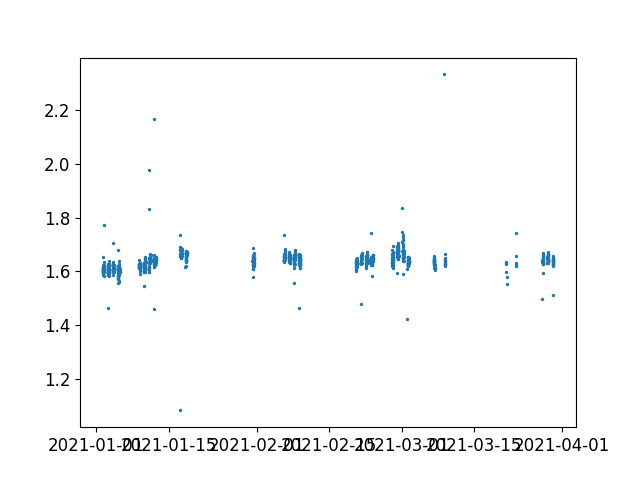

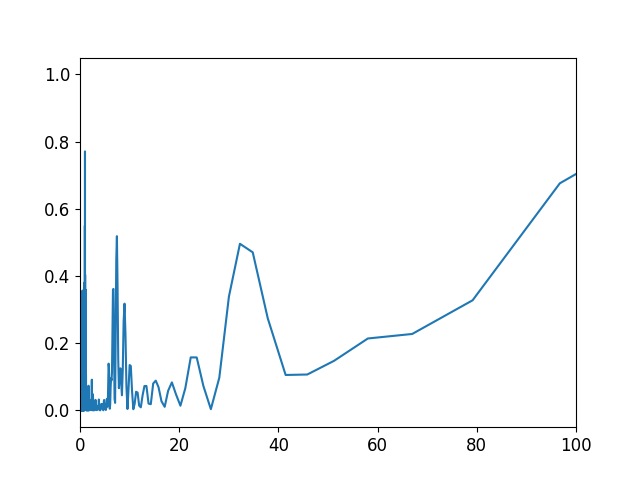

In [130]:
plt.figure()
dmags = [-2.5 * np.log(phot_table['aperture_sum'][0]/np.mean(phot_table['aperture_sum'][1:])) for phot_table in results]
plt.scatter(times, dmags, s=2)
t_new, y_new = remove_nans(dt64_to_days(times), dmags)
frequency, power = LombScargle(t_new, y_new).autopower()
plt.figure()
plt.plot(1/frequency, power)
plt.xlim(0,100)

plt.figure()
dmags2 = [-2.5 * np.log(phot_table['aperture_sum'][1]/np.mean(phot_table['aperture_sum'][2:])) for phot_table in results]
plt.scatter(times, dmags2, s=2)
t_new, y_new = remove_nans(dt64_to_days(times), dmags2)
frequency, power = LombScargle(t_new, y_new).autopower()
plt.figure()
plt.plot(1/frequency, power)
plt.xlim(0,100)

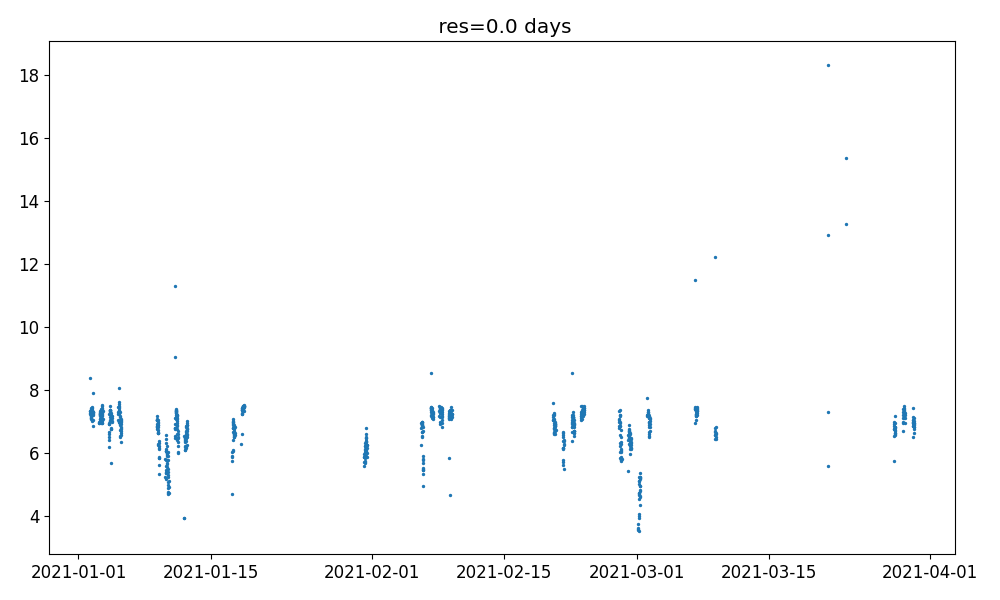

In [63]:

#lc = Timeseries(times, dmags)
lc = pload('tek2k.p')
lc.scatter(s=2, figsize=(10,6))

Peak fitting failed. Using simple ACF period estimator.


10.001006562500258

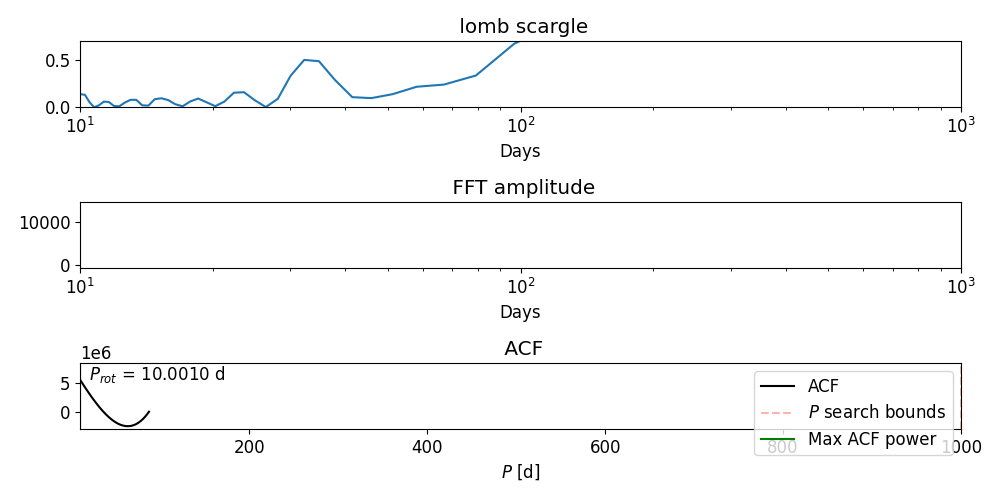

In [51]:
from util.timeseriestools import lomb_fft_acf
lomb_fft_acf(Timeseries(t_new, y_new))

In [ ]:
"""photutils.aperture with local background subtraction"""

In [ ]:
saturations = {'tek2k': 28000, 'nd12': 28000, 'Marana': 56000, 'acam': 56000}
plate_scales = {'tek2k': .3252, 'nd12': .20325, 'Marana': .44, 'acam': 0.6}
dr_tek2k = 3.8
version='_v3'
def save_cntrds(cntrds, fn):
    foo = cntrds.copy()
    foo.attrs['compcoords'] = str(foo.compcoords)
    foo.to_netcdf(fn, mode='w')
print(f'{len(comps)} comps')


scope = {'tek2k' : 61, 'nd12': 61, 'Marana': 13, 'acam': 13}
for i in [2.0, 2.5, 3.0, 3.5, 4.0, 6.0]:
    for c in ['tek2k', 'nd12', 'Marana', 'acam']: # 'tek2k', 'nd12', 'Marana'
        outpath = f'/users/canis/dev/holmberg/out/{c}/seeing_below_{i}/cntrds{version}.nc'                
        if os.path.exists(outpath):
            log.info(f'{i} {c} {n} already done')
            continue

        dr = dr_tek2k * plate_scales['tek2k'] / plate_scales[c]
        bw = 7 * plate_scales['tek2k'] / plate_scales[c]
        sa = 15 * plate_scales['tek2k'] / plate_scales[c]

        log.info(f'{c} {i}')
        log.info(f'Using saturation={saturations[c]}')
        log.info(f'Using disk radius ={dr} {bw} {sa}')
        log.info(f'Using {len(comps)} comps')

        fdir = f'{HOME}/data/cameras/{c}/seeing_below_{i}'
        flist = sorted(glob.glob(f'{fdir}/*.a.nc'))
        try:
            cntrds = mphot.aperphot(flist, startcoords=target,
                                compcoords=comps, ncompmax=5, snrmin=100,
                                diskradius=dr, bufferwidth=bw, skyannulus=sa,
                                Nthresh=2.4, autoradius='fixed', emax=0.5,
                                saturation=saturations[c],
                                nhist=1, quick='noctrd', maxcpus=None, verbose=True)
            save_cntrds(cntrds, outpath)
        except Exception as e:
            print(e)
            print('HEY')


## aperphot: compstars

In [ ]:
print(len(comps))
for i in [3.0]:
    for n in range(len(comps)):
        for c in ['tek2k', 'nd12', 'Marana', 'acam']:
#             if c=='acam' and i==2.0:
#                 continue
            outpath = f'{HOME}/data/centroids/{c}/seeing_below_{i}/cntrds{version}_{n+1}.nc'

            if os.path.exists(outpath):
                log.info(f'{i} {c} {n+1} already done')
                continue

            dr = dr_tek2k * plate_scales['tek2k'] / plate_scales[c]
            bw = 7 * plate_scales['tek2k'] / plate_scales[c]
            sa = 15 * plate_scales['tek2k'] / plate_scales[c]

            log.info(f'{c} {i} {n+1}')
            log.info(f'Using saturation={saturations[c]}')
            log.info(f'Using disk radius ={dr} {bw} {sa}')

            fdir = f'{HOME}/data/cameras/{c}/seeing_below_{i}'
            flist = sorted(glob.glob(f'{fdir}/*.a.nc'))

            if n == 0:
                used_comps = comps[1:]
            elif n == len(comps) - 1:
                used_comps =  comps[:n]
            else:
                used_comps = list(np.concatenate([comps[:n], comps[n+1:]])) # avoid truth error
            try:
                cntrds = mphot.aperphot(flist, startcoords=target,
                                    compcoords=comps, ncompmax=5, snrmin=100,
                                    diskradius=dr, bufferwidth=bw, skyannulus=sa,
                                    Nthresh=2.4, autoradius='fixed', emax=0.5,
                                    saturation=saturations[c],
                                    nhist=1, quick='noctrd', maxcpus=None, verbose=True)
                save_cntrds(cntrds, outpath)
            except Exception as e:
                print(e)
                print('HEY')